In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 3: item invariance

In [2]:
dif = read_csv('stan_results/dif.csv')
print('distractor')
print((dif.p1 < 0.05).sum(), (dif.p1 < 0.05).mean())
print((dif.fwe1 < 0.05).sum(), (dif.fwe1 < 0.05).mean())
print('shape set')
print((dif.p2 < 0.05).sum(), (dif.p2 < 0.05).mean())
print((dif.fwe2 < 0.05).sum(), (dif.fwe2 < 0.05).mean())

distractor
46 0.71875
25 0.390625
shape set
35 0.546875
12 0.1875


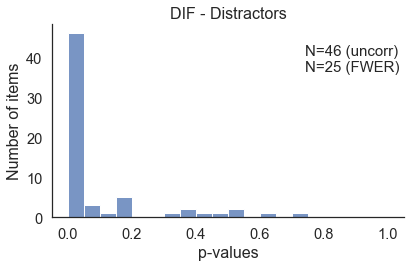

In [22]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot distribution.
sns.histplot(dif.p1, bins=np.linspace(0,1,21), ax=ax)

## Add detail.
ax.set(xlabel='p-values', ylabel='Number of items', title='DIF - Distractors')
ax.annotate('N=%s (uncorr)\nN=%s (FWER)' %((dif.p1 < 0.05).sum(), (dif.fwe1 < 0.05).sum()),
            xy=(0,0), xytext=(0.72,0.90), xycoords='axes fraction', fontsize=15, va='top')

sns.despine()
plt.tight_layout()

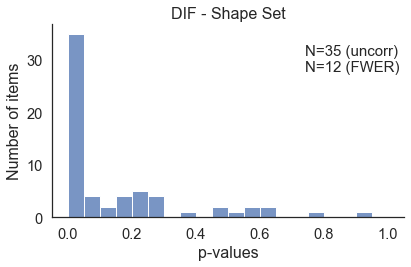

In [23]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot distribution.
sns.histplot(dif.p2, bins=np.linspace(0,1,21), ax=ax)

## Add detail.
ax.set(xlabel='p-values', ylabel='Number of items', title='DIF - Shape Set')
ax.annotate('N=%s (uncorr)\nN=%s (FWER)' %((dif.p2 < 0.05).sum(), (dif.fwe2 < 0.05).sum()),
            xy=(0,0), xytext=(0.72,0.90), xycoords='axes fraction', fontsize=15, va='top')

sns.despine()
plt.tight_layout()

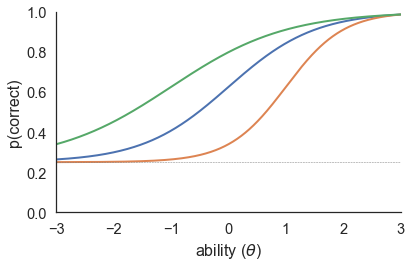

In [35]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

theta = np.linspace(-3,3,1001)

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(theta, 0.25 + (1-0.25) * inv_logit(1.33 * theta - 0), lw=2)
ax.plot(theta, 0.25 + (1-0.25) * inv_logit(2.00 * theta - 2), lw=2)
ax.plot(theta, 0.25 + (1-0.25) * inv_logit(1.00 * theta + 1), lw=2)

ax.set(xlabel=r'ability ($\theta$)', ylabel='p(correct)', xlim=(-3,3), ylim=(0,1))
ax.axhline(0.25, color='0.5', lw=0.5, linestyle='--')

sns.despine()
plt.tight_layout()

In [ ]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

d0 = inv_logit(dif.b0 + dif.b2) - inv_logit(dif.b0)
sns.histplot(d0)

In [ ]:
d2 = np.column_stack([
    inv_logit(dif.b0 + dif.b3) - inv_logit(dif.b0),
    inv_logit(dif.b0 + dif.b4) - inv_logit(dif.b0),
    inv_logit(dif.b0 + dif.b4) - inv_logit(dif.b0 + dif.b3)
])

dmax = np.abs(d2).max(axis=1)

sns.stripplot(x=dif.fwe2 < 0.05, y=dmax, hue=dif.p2 < 0.05)

In [ ]:
from statsmodels.api import Logit

n_subj = 1500
n_item = 64
n_vers = 6
n_test = 16
gamma = 0.25

np.random.seed(47404)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x - np.mean(x)) / np.std(x)

theta = np.random.normal(0, 1, n_subj)

beta = np.random.normal(0, 1, n_item)
beta = np.repeat(np.sort(beta), n_vers)

alpha = np.exp(np.random.normal(np.log(1/(1-gamma)), 0.15, n_item))
alpha = np.repeat(alpha, n_vers)

J = np.repeat(np.arange(n_subj), n_test)
N = len(J)

a = np.arange(n_item * n_vers // n_test)
b = np.arange(0, n_item * n_vers, a.max()+1)

K = []
for _ in range(n_subj): 
    K = np.concatenate([K, np.random.choice(a, n_test, replace=True) + b]).astype(int)
    
mu = np.zeros(N)
for n in range(N): mu[n] = inv_logit(alpha[K[n]] * theta[J[n]] - beta[K[n]])
    
Y = np.random.binomial(1, gamma + (1-gamma) * mu)
sum_scores = np.array([sum(Y[J==j]) for j in range(n_subj)])

params = []

for k in range(n_item):
    
    ## Define indices
    ix = K // n_vers == k
    
    y = Y[ix]
    
    x0 = np.ones_like(y)
    x1 = zscore(sum_scores[J[ix]] - y)
    x2 = K[ix] % 2
    x3 = np.where(K[ix] % 6 == 1, 1, 0)
    x4 = np.where(K[ix] % 6 == 2, 1, 0)
    
    fit = Logit(y, np.column_stack([x0, x1, x2, x3, x4])).fit(disp=0)
    
    ## Check convergence.
    if not fit.mle_retvals['converged']: 
        continue
        
    params.append(fit.params)
    
params = np.row_stack(params).round(6)

In [ ]:
sns.histplot(np.concatenate([dif.b3, dif.b4]), bins=np.linspace(-2,2,11), color='#4c72b0')
sns.histplot(np.concatenate([params[:,3], params[:,4]]), bins=np.linspace(-2,2,11), color='#dd8452')

In [ ]:
sns.histplot(dif.b2, bins=np.linspace(-2,2,11), color='#4c72b0')
sns.histplot(params[:,2], bins=np.linspace(-2,2,11), color='#dd8452')